In [1]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

2025-09-12 16:02:39.871562: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 16:02:39.872706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-12 16:02:39.896839: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-12 16:02:39.897331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-12 16:02:40.379103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [6]:
FILENAME = 'waymo-od/tutorial/frames'
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(data.numpy())   # <- this is already bytes
    break

In [8]:
print(frame.context)

name: "11004685739714500220_2300_000_2320_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.5561493616392
  intrinsic: 2055.5561493616392
  intrinsic: 939.65746988614683
  intrinsic: 641.07218219432707
  intrinsic: 0.032316008497988873
  intrinsic: -0.32141248255270588
  intrinsic: 0.00079325839537099725
  intrinsic: -0.00062574935413338471
  intrinsic: 0
  extrinsic {
    transform: 0.99989268498874273
    transform: -0.0059932084000160583
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.0060422365213296629
    transform: 0.99997515605479947
    transform: -0.0036302411764970719
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.0037106234318779619
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0
    transform: 0
    transform: 0
    transform: 1
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  int

In [16]:
from waymo_open_dataset.utils import frame_utils as fu
import inspect, re

src = inspect.getsource(fu.parse_range_image_and_camera_projection)
patched = re.sub(r'ParseFromString\(\s*bytearray\((.*?)\)\s*\)',
                 r'ParseFromString(bytes(\1))',
                 src)

ns = {}
exec(patched, fu.__dict__, ns)
fu.parse_range_image_and_camera_projection = ns['parse_range_image_and_camera_projection']

# Now use it as usual:
range_images, camera_projections, _, range_image_top_pose = (
    fu.parse_range_image_and_camera_projection(frame)
)

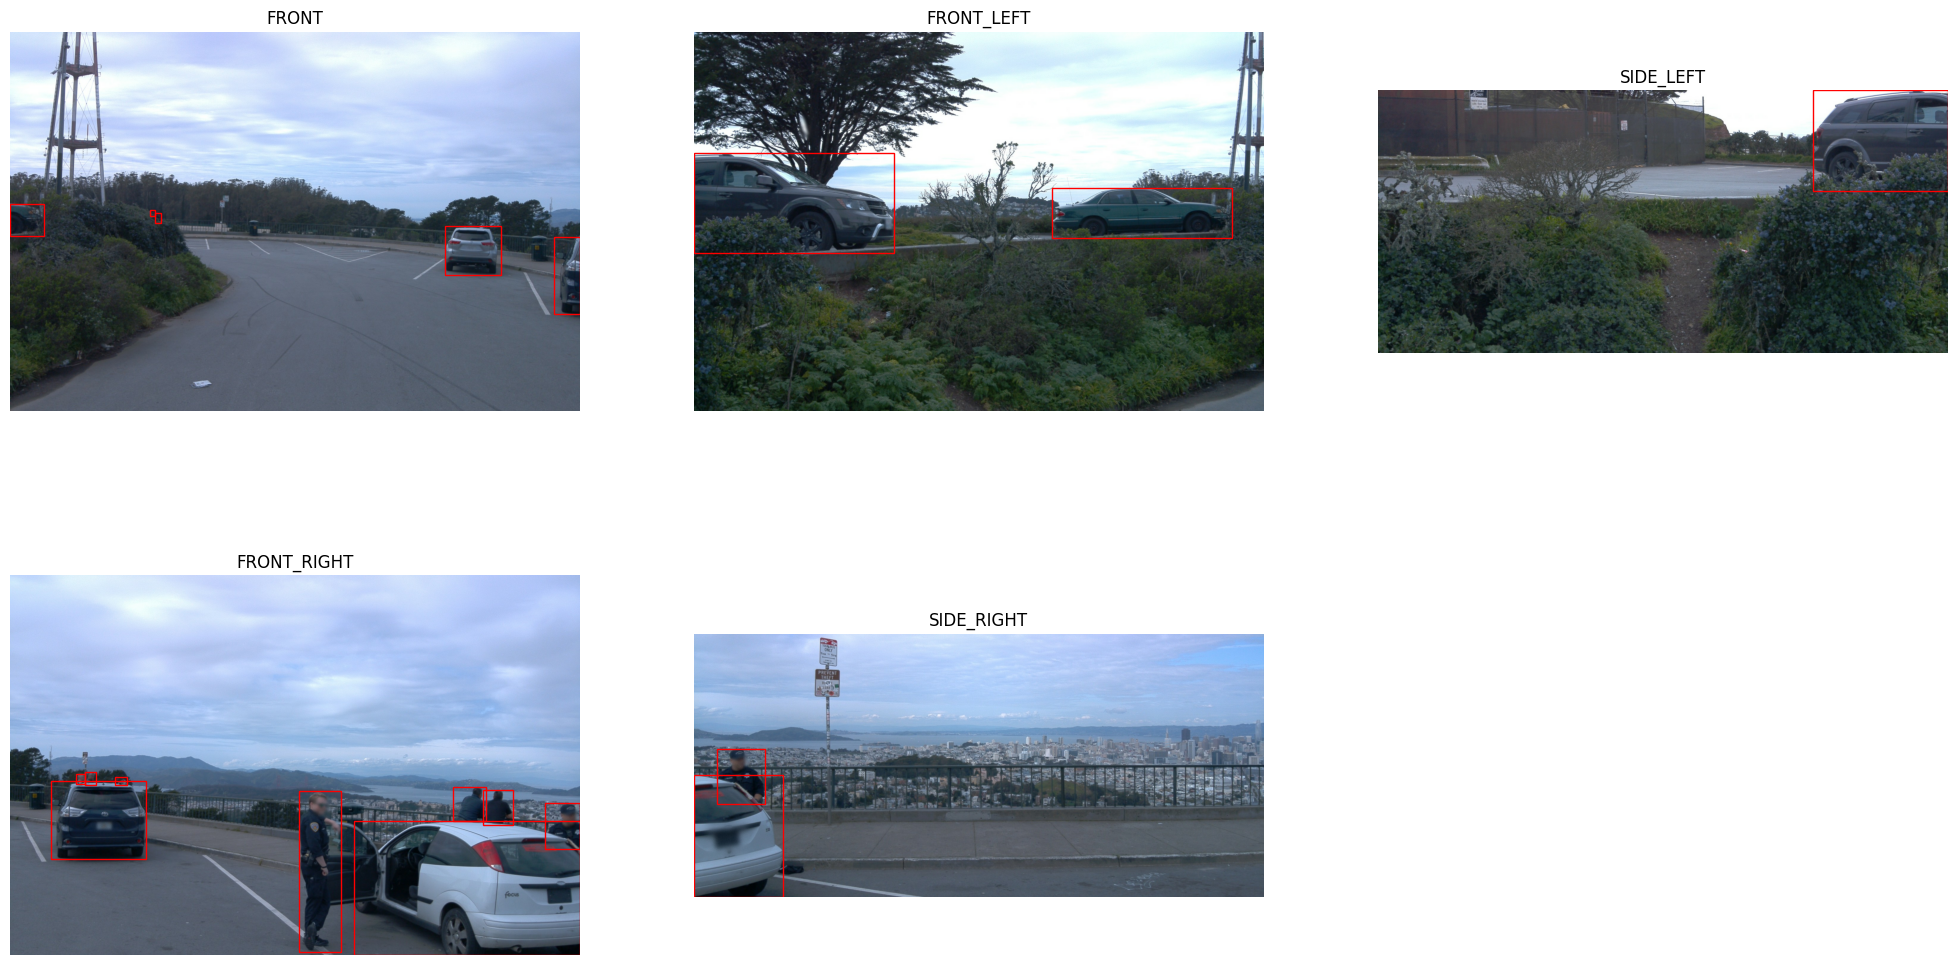

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

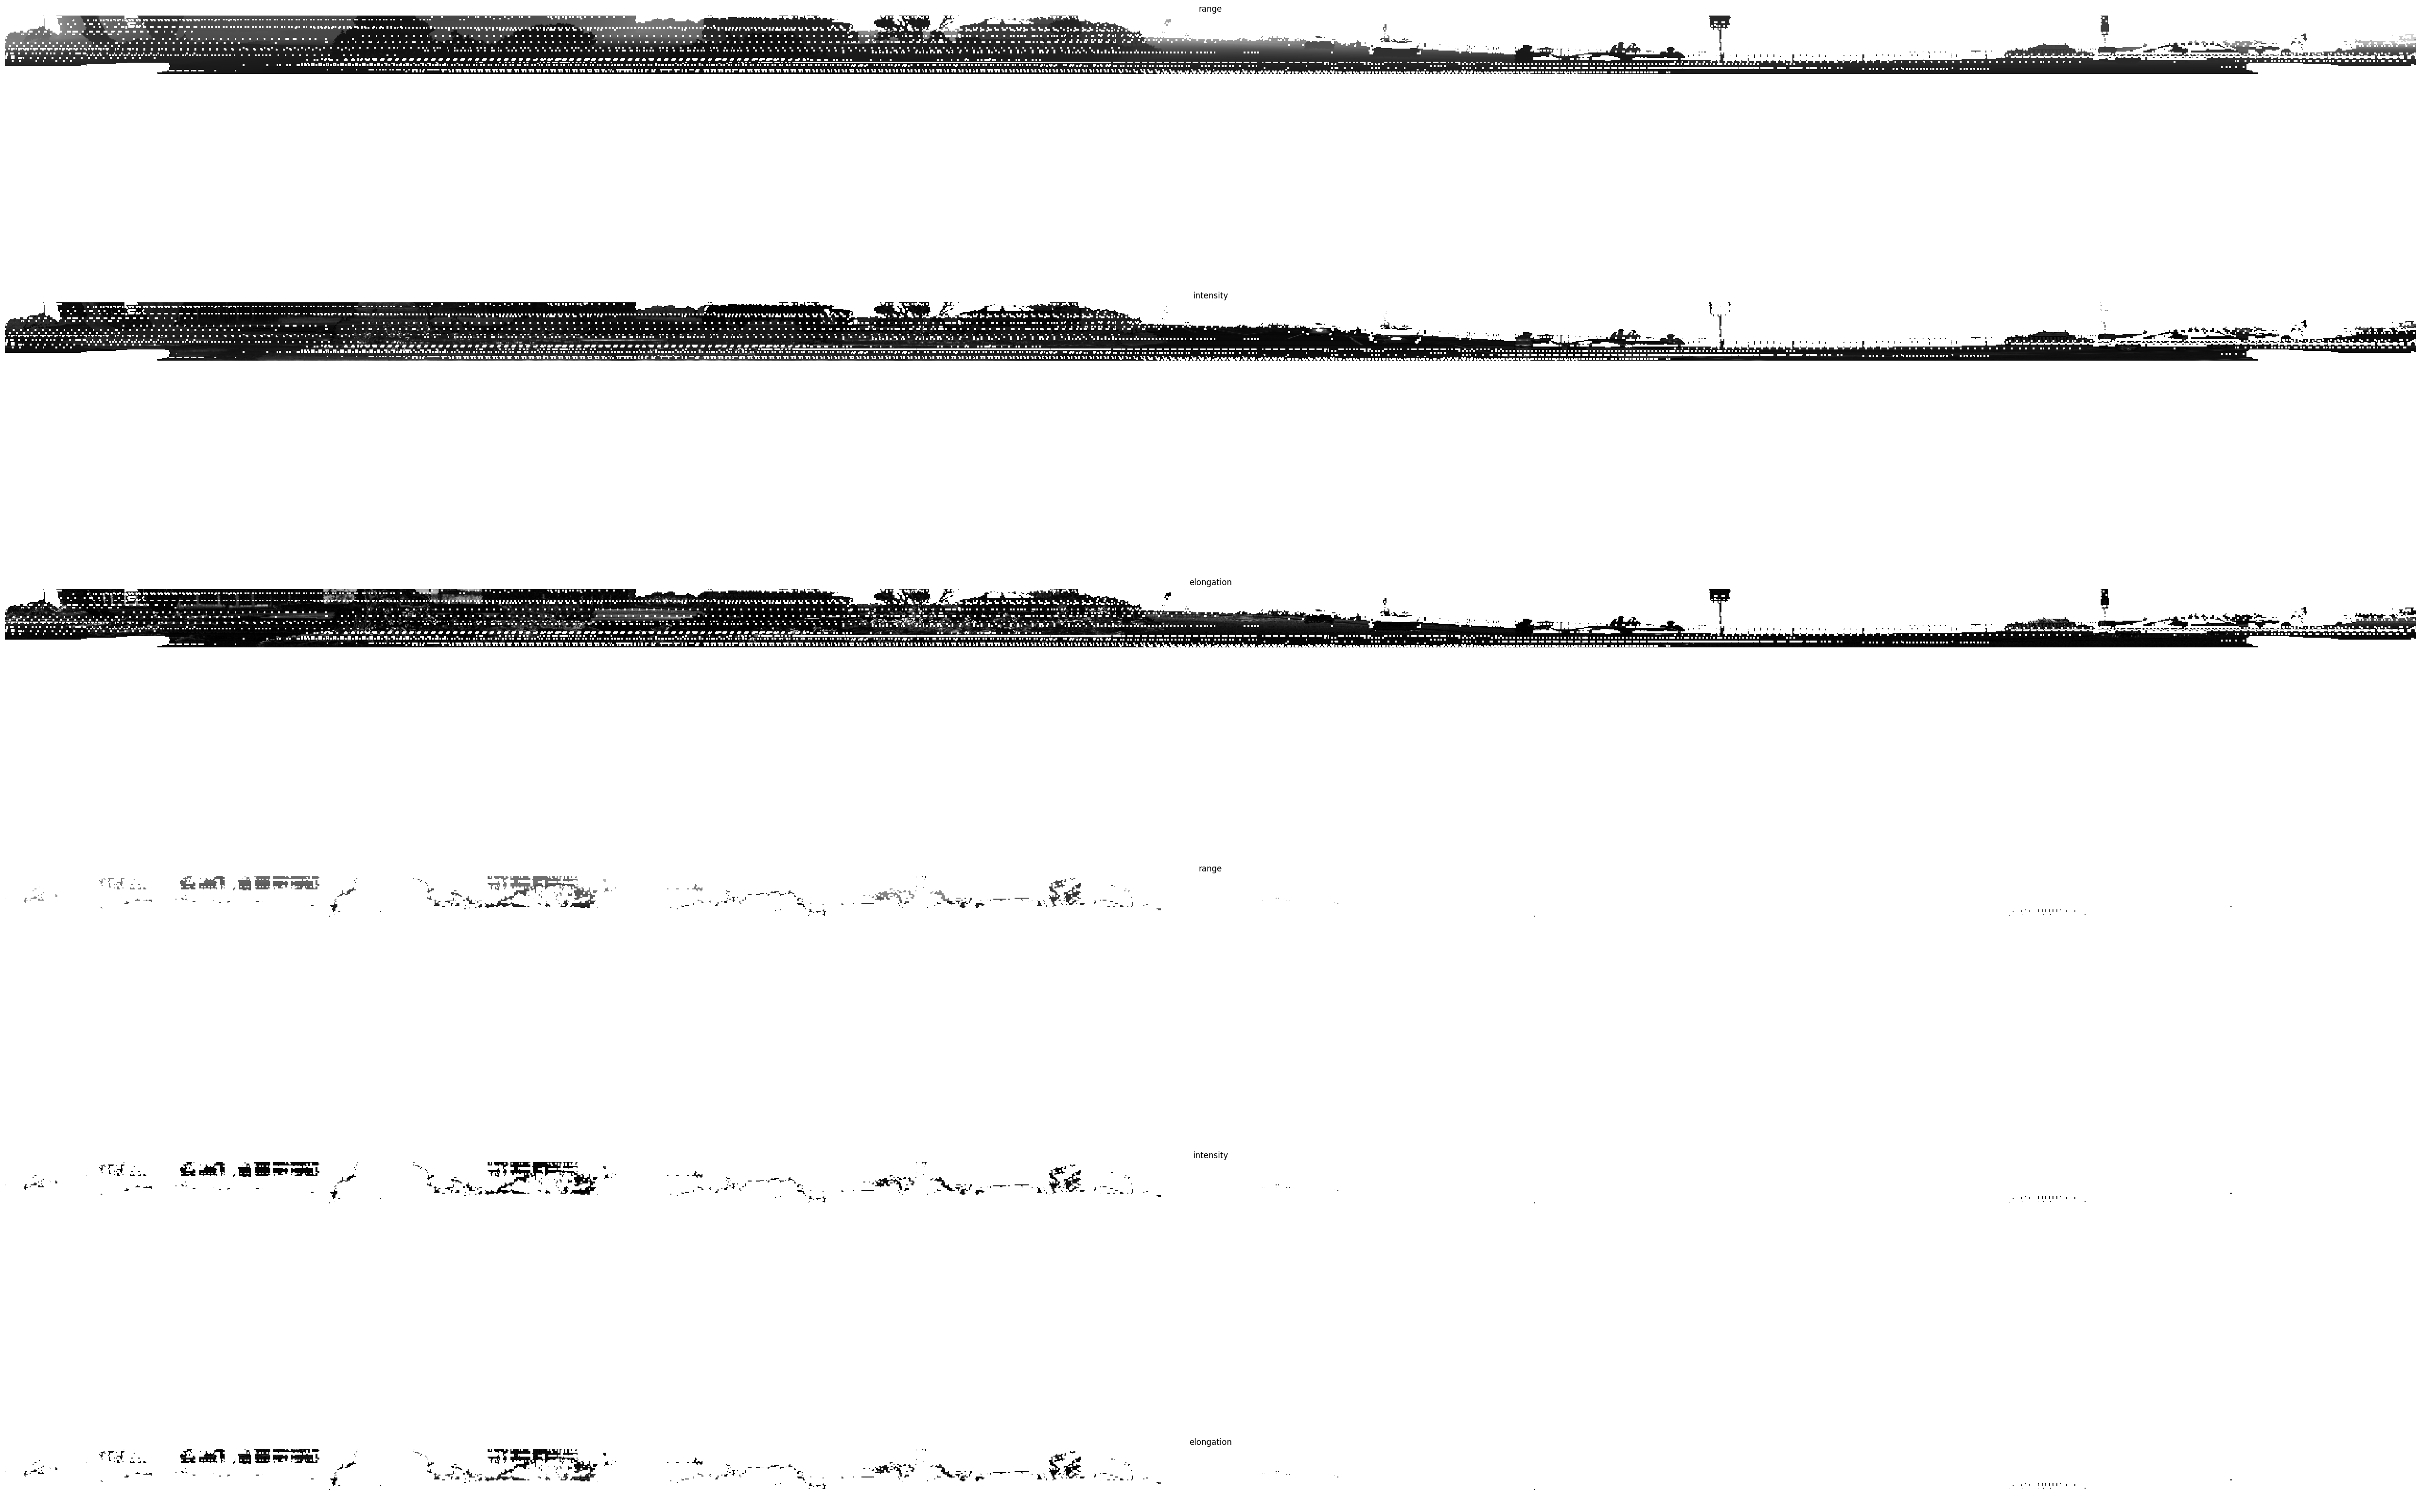

In [21]:
plt.figure(figsize=(64, 60))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0]
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

In [22]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

In [24]:
print(points_all.shape)

(126059, 3)


In [25]:
print(cp_points_all.shape)

(126059, 6)


In [26]:
print(points_all[0:2])

[[-51.13867     5.100586    4.3288727]
 [-51.3291      5.243164    4.3369293]]


In [27]:
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(108996, 3)
(108996, 6)
(3819, 3)
(3819, 6)
(4918, 3)
(4918, 6)
(3850, 3)
(3850, 6)
(4476, 3)
(4476, 6)
